# Evaluate Unit-wget model over MPI and Era

This notebook evaluates different CNN autoencoder models on things like 1) monthly averages and 2) climate. The selected model tries to bias correct Mpi to Era and Era to MPI.

### TOC
 [1. Model Select](#ms)<br>
 [2. Load data](#ld)<br>
 [3. Month averages](#ma)<br>
 [4. Single day bias](#sd)<br>
 [5. Single filter activations](#sfa)<br>
 [6. Quantile plots](#qp)<br>
 





In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
bce = nn.BCELoss()
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
from IPython.display import display, HTML

In [3]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


In [4]:
from torch import nn
mse = nn.MSELoss()
mae = nn.L1Loss()

import math


In [5]:
# define internal pic res
ires = 64
res = 64
nvars = 18
mnvars = 18


In [6]:
 mnvars
    

18

<a id='ms'></a>
## Models: run one from below:


In [7]:
import torch.nn.functional as F


In [8]:
class Conv2dBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding=0, norm='none', activation='relu', pad_type='zero'):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'lonwrap':
            self.pad = LatLonPad(padding, lon_dim=-1)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            #self.norm = nn.InstanceNorm2d(norm_dim, track_running_stats=True)
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        self.activation = MultiChannelActivation(activation, output_dim)

        # initialize convolution
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias)

    def forward(self, x):
        #print("x", x)
        #print("SHAPE1 x", x.shape)
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x


class Encoder(nn.Module):
    def __init__(self, n_downsample, n_res, input_dim, dim, norm, activ, pad_type):
        super(Encoder, self).__init__()
        #input_dim, output_dim, kernel_size, stride, padding
        # This layer conserves lat-lon
        self.model = [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        # downsampling blocks
        for i in range(n_downsample):
            # This layer coarsens lat-lon by factor 2
            self.model += [
                Conv2dBlock(dim, 2*dim,
                            kernel_size=4, stride=2, padding=1,
                            norm=norm, activation=activ, pad_type=pad_type)
            ]
            # residual blocks maintain lat-lon shape
            if n_res>0:
                self.model += [ResBlocks(n_res, 2*dim, norm='none', activation=activ, pad_type=pad_type)]
            dim *= 2

        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_upsample, n_res, dim, output_dim, norm,
                 activ='relu', pad_type='zero', output_activ='none', upsample='nearest'):
        super(Decoder, self).__init__()

        if upsample=='nearest':
            def _decode_upsampler(C): return nn.Upsample(scale_factor=2, mode='nearest')
        elif upsample=='bilinear':
            def _decode_upsampler(C): return nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        elif upsample=='conv':
            def _decode_upsampler(C): return nn.ConvTranspose2d(C, C, kernel_size=2, stride=2)
        else:
            assert 0, "`upsample` must be one of ['nearest', 'bilinear', 'conv']"

        self.model = []
        # residual blocks
        if n_res>0:
            self.model += [ResBlocks(n_res, dim, norm, activ, pad_type=pad_type)]
        # upsampling blocks
        for i in range(n_upsample):
            self.model += [_decode_upsampler(dim)]
            self.model += [Conv2dBlock(dim, dim//2, 5, 1, 2,
                                       norm=norm, activation=activ, pad_type=pad_type)]
            if n_res>0:
                self.model += [ResBlocks(n_res, dim//2, norm='none', activation=activ, pad_type=pad_type)]
            dim //= 2

        self.model += [Conv2dBlock(dim, output_dim, 7, 1, 3, norm='none', activation=output_activ, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)


    def forward(self, x):
        return self.model(x)

def get_activation(activation):
        # initialize activation
    if activation == 'relu':
        return nn.ReLU(inplace=False)
    elif activation == '-relu':
        return NegReLU()
    elif activation == 'lrelu':
        return nn.LeakyReLU(0.2, inplace=True)
    elif activation == 'prelu':
        return nn.PReLU()
    elif activation == 'selu':
        return nn.SELU(inplace=True)
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'none':
        return None
    else:
        assert 0, "Unsupported activation: {}".format(activation)

    
class MultiChannelActivation(nn.Module):
    def __init__(self, activation, output_dim):
        super(MultiChannelActivation, self).__init__()
        if isinstance(activation, str):
            activation = [activation]
        elif (not isinstance(activation, list)) or len(activation)!=output_dim:
            raise ValueError(f"Not valid activation {activation} for channels {output_dim}")

        self.activation = [get_activation(a) for a in activation]

    def forward(self, x):
        if len(self.activation)==1:
            if self.activation[0] is not None:
                return self.activation[0](x)
            else:
                return x
        else:
            x_list = [self.activation[i](x[:, i:i+1]) if self.activation[i] is not None else x[:, i:i+1] for i in range(x.shape[1])]
            x = torch.cat(x_list, dim=1)
            return x

##################################################################################
# Sequential Models
##################################################################################

class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='lrelu', pad_type='zero'):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)


##################################################################################
# Basic Blocks
##################################################################################

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='lrelu', pad_type='zero'):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim, dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        model += [Conv2dBlock(dim, dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = residual + self.model(x)
        return out


  
    
class VAEGen(nn.Module):
    # VAE architecture
    def __init__(self, input_dim, land_mask, params):
        super(VAEGen, self).__init__()
        
        
        dim = params['dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']
        output_activ = 'none' #params['output_activ']
        upsample = params['upsample']
        norm = 'bn' #params['norm']
        self.use_land_mask = land_mask is not None
        self.land_mask = nn.Parameter(land_mask, requires_grad=False)

        
#         dim = params['dim']
#         n_downsample = params['n_downsample']
#         n_res = params['n_res']
#         activ = params['activ']
#         pad_type = params['pad_type']
#         output_activ = 'none' #params['output_activ']
#         upsample = 'nearest' #params['upsample']
#         norm = 'bn' #params['norm']
#         self.use_land_mask = land_mask is not None
#         self.land_mask = nn.Parameter(land_mask, requires_grad=False)

        # content encoder
        self.enc = Encoder(n_downsample, n_res, input_dim+int(self.use_land_mask),
                                  dim, norm, activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc.output_dim, input_dim, norm=norm,
                           activ=activ, pad_type=pad_type, output_activ=output_activ,
                           upsample=upsample)

    def forward(self, images):
        # This is a reduced VAE implementation where we assume the outputs are multivariate Gaussian distribution with mean = hiddens and std_dev = all ones.
        hiddens = self.encode(images)
        if 0 and self.training:
            #print("hiddens", hiddens)
            #noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
            noise = Variable(torch.randn(hiddens.size()))
            images_recon = self.decode(hiddens + noise)
        else:
            images_recon = self.decode(hiddens)
        return images_recon, hiddens

    def encode(self, images):
        if self.use_land_mask:
            images = torch.cat([images, self.land_mask.clone().detach().repeat(images.shape[0],1,1,1)], dim=1)
        hiddens = self.enc(images)
        #noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
        noise = Variable(torch.randn(hiddens.size()))
        return hiddens, noise
    
    def decode(self, hiddens):
        images = self.dec(hiddens)
        return images
    
##################################################################################
# Discriminator
##################################################################################

class MsImageDis(nn.Module):
    # Multi-scale discriminator architecture
    def __init__(self, input_dim, land_mask, params):
        super(MsImageDis, self).__init__()
        self.n_layer = params['n_layer']
        self.gan_type = params['gan_type']
        self.dim = params['dim']
        self.norm = params['norm']
        self.activ = params['activ']
        self.num_scales = params['num_scales']
        self.pad_type = params['pad_type']

        self.input_dim = input_dim
        self.use_land_mask = land_mask is not None
        self.land_mask = nn.Parameter(land_mask, requires_grad=False)
        self.downsample = nn.AvgPool2d(2, stride=2, padding=0, count_include_pad=False)

        self.cnns = nn.ModuleList()
        for _ in range(self.num_scales):
            self.cnns.append(self._make_net())

    def _make_net(self):
        dim = self.dim
        cnn_x = [
            Conv2dBlock(
                (self.input_dim+int(self.use_land_mask)), dim, 7, 1, 3,
                norm='none',
                activation=self.activ,
                pad_type=self.pad_type),
            Conv2dBlock(dim, dim, 4, 2, 1,
              norm=self.norm,
              activation=self.activ,
              pad_type=self.pad_type)
        ]
        for i in range(self.n_layer  - 1):
            cnn_x += [Conv2dBlock(dim, dim * 2, 4, 2, 1,
                                  norm=self.norm,
                                  activation=self.activ,
                                  pad_type=self.pad_type)
            ]
            dim *= 2
        cnn_x += [nn.Conv2d(dim, 1, 1, 1, 0)]
        cnn_x = nn.Sequential(*cnn_x)
        return cnn_x

    def forward(self, x):
        outputs = []
        if self.use_land_mask:
            x = torch.cat([x, self.land_mask.clone().detach().repeat(x.shape[0],1,1,1)], dim=1)
        #print('SELF.CNNS', self.cnns)
        for model in self.cnns:
            #print('OIOIH', model, x)
            #model.cuda()
            #x.cuda()
            #print(model(x))
            outputs.append(model(x))
            x = self.downsample(x)
        return outputs

    def calc_dis_loss(self, input_fake, input_real):
        # calculate the loss to train D
        outs0 = self.forward(input_fake)
        outs1 = self.forward(input_real)
        loss = 0

        for it, (out0, out1) in enumerate(zip(outs0, outs1)):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 0)**2) + torch.mean((out1 - 1)**2)
            elif self.gan_type == 'nsgan':
                all0 = Variable(torch.zeros_like(out0.data).cuda(), requires_grad=False)
                all1 = Variable(torch.ones_like(out1.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all0) +
                                   F.binary_cross_entropy(F.sigmoid(out1), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

    def calc_gen_loss(self, input_fake):
        # calculate the loss to train G
        outs0 = self.forward(input_fake)
        loss = 0
        for it, (out0) in enumerate(outs0):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 1)**2) # LSGAN
            elif self.gan_type == 'nsgan':
                all1 = Variable(torch.ones_like(out0.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss


    
def resume(checkpoint_dir, hyperparameters):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen")
        state_dict = torch.load(last_model_name)
        gen_a.load_state_dict(state_dict['a'])
        gen_b.load_state_dict(state_dict['b'])
        iterations = int(last_model_name[-11:-3])
        # Load discriminators
        last_model_name = get_model_list(checkpoint_dir, "dis")
        state_dict = torch.load(last_model_name)
        dis_a.load_state_dict(state_dict['a'])
        dis_b.load_state_dict(state_dict['b'])
        # Load optimizers
        state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
        dis_opt.load_state_dict(state_dict['dis'])
        gen_opt.load_state_dict(state_dict['gen'])
        ## Reinitilize schedulers
        #dis_scheduler = get_scheduler(dis_opt, hyperparameters, iterations)
        #gen_scheduler = get_scheduler(gen_opt, hyperparameters, iterations)
        print('Resume from iteration %d' % iterations)
        return iterations


# # Config
# #import yaml
# #with open('hadgem3_to_cam5_nat-hist-4channels.yaml', 'r') as stream:
# #        config = yaml.load(stream)
# gen = {'dim': 64, 'mlp_dim': 256, 'style_dim': 8, 'activ': 'relu', 'n_downsample': 2, 'n_res': 4, 'pad_type': 'zero'}
# dis = {'dim': 64, 'norm': 'none', 'activ': 'lrelu', 'n_layer': 4, 'gan_type': 'lsgan', 'num_scales': 3, 'pad_type': 'reflect'}



# # load generator
# gen_a = VAEGen(64, None, gen) 
# gen_b = VAEGen(64, None, gen) 
# state_dict = torch.load('/glade/scratch/dkorytin/delme/gen_00945001.pt', map_location=torch.device('cpu'))
# gen_a.load_state_dict(state_dict['a'])
# gen_b.load_state_dict(state_dict['b'])

# # load discriminator
# state_dict = torch.load('/glade/scratch/dkorytin/delme/dis_00945001.pt', map_location=torch.device('cpu'))
# dis_a = MsImageDis(64, None, dis)  # discriminator for domain a
# dis_a.load_state_dict(state_dict['a'])

In [9]:
# 16 filters, 4ds
gen = {'dim': 16, 'mlp_dim': 512, 'style_dim': 8, 'activ': 'lrelu', 'n_downsample': 4, 'n_res': 3, 'pad_type': 'zero', 'upsample': 'conv'}
dis = {'dim': 128, 'norm': 'none', 'activ': 'lrelu', 'n_layer': 4, 'gan_type': 'lsgan', 'num_scales': 3, 'pad_type': 'zero'}

# load generator
gen_a = VAEGen(18, None, gen) 
gen_b = VAEGen(18, None, gen) 
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-drop2-ssim-simenc2/output/gen_00385001.pt', map_location=torch.device('cpu'))
state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-drop2-ssim-simenc2/output/gen_02025001.pt', map_location=torch.device('cpu'))
gen_a.load_state_dict(state_dict['a'])
gen_b.load_state_dict(state_dict['b'])


<All keys matched successfully>

<a id='ld'></a>
# Load data

In [10]:
# WRF-MPI DOMAIN Ext1
samples_era = np.load('/glade/scratch/dkorytin/samples_wrferaext18_365.npy')
samples_mpi = np.load('/glade/scratch/dkorytin/samples_wrfmpiext18_365.npy')
samples_era[np.isnan(samples_era)] = 0.   # extended surface domain has nan's at bottom
samples_mpi[np.isnan(samples_mpi)] = 0.   # extended surface domain has nan's at bottom
samples_era = torch.tensor(samples_era, dtype=torch.float32)
samples_mpi = torch.tensor(samples_mpi, dtype=torch.float32)
minmaxi_era = np.load('/glade/scratch/dkorytin/minmaxi_wrferaext18.npy')
minmaxi_mpi = minmaxi_era


In [11]:
# Weather anomalies from paper
storms = np.load('/glade/scratch/dkorytin/storms_wrferaext18.npy')
storms[np.isnan(storms)] = 0.   # extended surface domain has nan's at bottom
storms = torch.tensor(storms, dtype=torch.float32)
minmaxi_era = np.load('/glade/scratch/dkorytin/minmaxi_wrferaext18.npy')
minmaxi_mpi = minmaxi_era


In [12]:
# 0-mean
era_mean = np.array([0.535485  , 0.4519444 , 0.28083166, 0.6958344 , 0.74353546,
        0.7667949 , 0.45282447, 0.53518105, 0.02868525, 0.3436686 ,
        0.32084906, 0.27729246, 0.26444143, 0.06457039, 0.1160536 ,
        0.11771968, 0.27282715, 0.4996573 ], dtype='float32').reshape((1, 18, 1, 1))
mpi_mean = np.array([0.5344214 , 0.45174   , 0.2868751 , 0.67098534, 0.7369371 ,
        0.75135934, 0.44308293, 0.5318341 , 0.03761845, 0.18091248,
        0.18680423, 0.1376027 , 0.13063669, 0.06532818, 0.14322543,
        0.11771968, 0.27282715, 0.4996573 ], dtype='float32').reshape((1, 18, 1, 1))
samples_mpi = samples_mpi - mpi_mean
samples_era = samples_era - era_mean
storms = storms - era_mean


In [13]:
samples_era.shape, storms.shape


(torch.Size([365, 18, 192, 256]), torch.Size([26, 18, 192, 256]))

(192, 256)


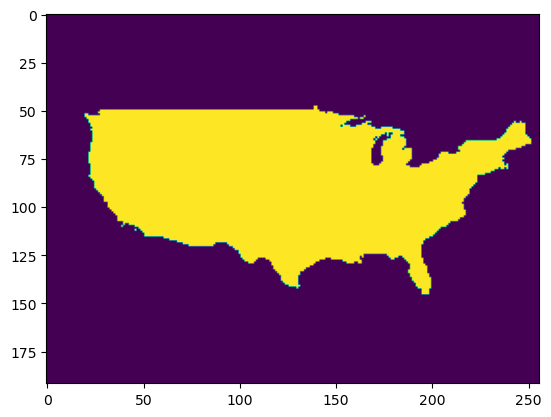

In [14]:
# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
mask.shape
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.
print(mask.shape)
plt.imshow(mask[::-1,:])

# zero out mask borders in surface vars
samples_mpi[:,8:,:,:] = samples_mpi[:,8:,:,:] * mask[None,None,:,:]
samples_era[:,8:,:,:] = samples_era[:,8:,:,:] * mask[None,None,:,:]
storms[:,8:,:,:] = storms[:,8:,:,:] * mask[None,None,:,:]


### Sinusoial embeddings

In [15]:
def get_sinusoidal_embedding(batch_size, sequence_length, d_model):
    """
    Generates a tensor with sinusoidal embeddings of positions.
    The tensor is of shape (batch_size, 2, seq_len, d_model).
    
    Args:
    - batch_size (int): number of sequences in a batch.
    - seq_len (int): length of each sequence.
    - d_model (int): dimensionality of the embedding.
    
    Returns:
    - embeddings (torch.Tensor): tensor of shape (batch_size, 2, seq_len, d_model), 
    containing sinusoidal embeddings for each position in each sequence.
    """

    pos = torch.arange(sequence_length).float().unsqueeze(0).unsqueeze(-1)
    dim = torch.arange(d_model).float().unsqueeze(0).unsqueeze(1)
    angle_rates = 1 / torch.pow(10000, (2 * (dim // 2)) / d_model)

    angle_rads = pos * angle_rates

    sin_even = torch.sin(angle_rads[:, :, 0::2])
    cos_odd = torch.cos(angle_rads[:, :, 1::2])

    pos_encoding = torch.cat([sin_even, cos_odd], dim=-1)
    pos_encoding = pos_encoding.unsqueeze(0).repeat(batch_size, 1, 1, 1)

    return pos_encoding

def add_sinusoidal_embedding(input_tensor, d_model):
    batch_size, _, sequence_length, _ = input_tensor.size()
    sinusoidal_embedding = get_sinusoidal_embedding(batch_size, sequence_length, d_model)
    input_tensor = torch.cat([input_tensor, sinusoidal_embedding.to(input_tensor.device)], dim=1)
    return input_tensor

# # Use-case
# dd = 261
# samples = samples_mpi[dd:dd+1, 0:17, 0:192, 0:192]
# samples = add_sinusoidal_embedding(samples, d_model=192)


In [16]:
from scipy.special import jv

# Compute the Bessel function using a recursive formula
def jv_simp(v, z):
    if v == 0:
        return np.sin(z) / z
    elif v == 1:
        return np.sin(z) / z**2 - np.cos(z) / z
    else:
        return (2 * (v-1) / z * jv_simp(v-1, z) - jv_simp(v-2, z))


def get_bessel_embedding(dims = (1, 1, 192, 256)):
    # Define the frequency of the sinusoidal function
    freq = 10

    # Create a meshgrid for the x and y coordinates
    x, y = np.meshgrid(np.linspace(-1, 1, dims[-1]), np.linspace(-1, 1, dims[-2]))

    # Compute the radius from the center of the meshgrid
    r = np.sqrt(x**2 + y**2)

    # Compute the Bessel function
    #bessel = jv(0, freq*r)
    bessel = jv_simp(0, freq*r)

    # Scale the Bessel function to lie between 0 and 1
    bessel = (bessel - np.min(bessel)) / (np.max(bessel) - np.min(bessel))

    # Compute the sinusoidal embedding function
    #embedding = np.sin(freq*np.pi*r) * bessel
    embedding = bessel

    # Reshape the embedding function to the desired dimensions
    embedding = embedding.reshape(dims)

    return embedding
# Print the shape of the embedding function
embedding = get_bessel_embedding(dims = (1, 1, 192, 256))
print(embedding.shape, embedding.min(), embedding.max())


(1, 1, 192, 256) 0.0 1.0


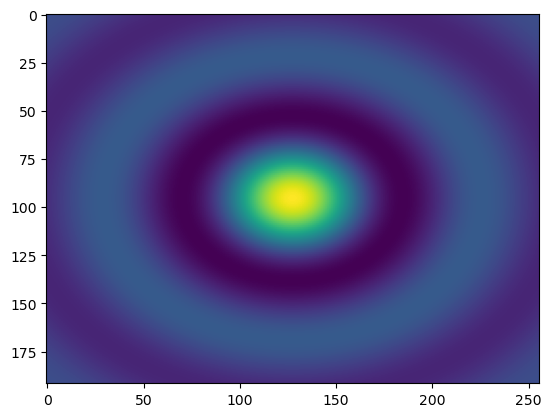

In [17]:
plt.imshow(embedding[0,0,::-1,:])

In [18]:
samples_mpi = torch.cat((samples_mpi[:, 0:17], torch.tensor(embedding).repeat(365, 1, 1, 1)), dim=1).to(dtype=torch.float32)
samples_era = torch.cat((samples_era[:, 0:17], torch.tensor(embedding).repeat(365, 1, 1, 1)), dim=1).to(dtype=torch.float32)
storms = torch.cat((storms[:, 0:17], torch.tensor(embedding).repeat(26, 1, 1, 1)), dim=1).to(dtype=torch.float32)


In [19]:
storms.shape

torch.Size([26, 18, 192, 256])

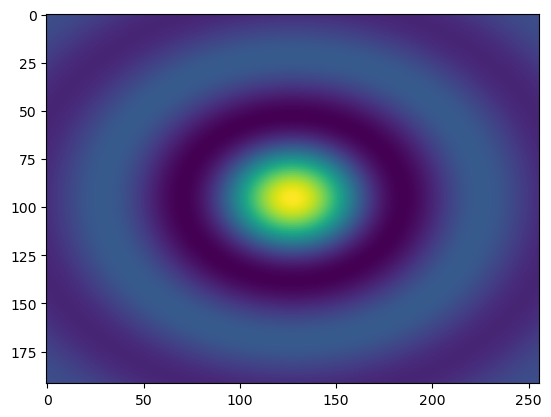

In [20]:
plt.imshow(storms.numpy()[25,17,::-1,:])

# Plot routines

In [32]:
import cartopy.feature as cfeature

In [43]:
# tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
# mask128 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))[:,12:12+128,69:69+128]
# mask128np = np.array(mask128[0])
# mask128np[mask128np>0] = 1
# mask128np[np.isnan(mask128np)] = 0.

# metadata used for lat/lon backdrop
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
dv1 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))

# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
mask.shape
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.


def plot_9v_192x256_abs(isample, modelname, vmin, vmax, svars=[8,9,10,11,12,13,14,15], cc=False, yoff=None, xoff=None, titles=None):
    varnames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250', 'prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'rsds', 'orog','miss','yday']
    if titles != None:
        varnames = titles
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s', 'mm/day', 'C', 'C', 'm/s', 'm/s', 'kg/kg', 'W/m2','m','0..1', '0..1']
    cmaps = ['PiYG', 'PuOr', 'PuBuGn', 'coolwarm', 'Spectral', 'Spectral', 'PiYG', 'PuOr', 'YlGnBu','coolwarm','coolwarm','PiYG','PuOr','PuBuGn','hot','terrain','binary','twilight_shifted']

    # if given 64x64, place it in zeros(192,256)
    if isample.shape == (18, 64, 64):
        zz = np.zeros((18, 192, 256))
        zz[0:18, yoff:yoff+64, xoff:xoff+64] = isample
        isample = zz
    
    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U850, V850
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))

    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))
    
    # min of Q850 should be 0
    vmin[2] = 0

    
    # Ranges centered on zero for U, V
    vmin[3+8] = -max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmax[3+8] = max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmin[4+8] = -max(abs(vmin[4+8]), abs(vmax[4+8]))
    vmax[4+8] = max(abs(vmin[4+8]), abs(vmax[4+8]))
 
    # Ranges centered on zero for tmin, tmax
    vmin[1+8] = -max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmax[1+8] = max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmin[2+8] = -max(abs(vmin[2+8]), abs(vmax[2+8]))
    vmax[2+8] = max(abs(vmin[2+8]), abs(vmax[2+8]))
    
    # prec min should be 0
    vmin[8] = 0

    # Plot borders
    fig, axarr = plt.subplots(1, 9, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = dv1[0].lon
    lat = dv1[0].lat
    
    # Plot 128x128 or 64x64 if offset is provideed
    if xoff and yoff:
        lon = dv1[0][yoff:yoff+64, xoff:xoff+64].lon
        lat = dv1[0][yoff:yoff+64, xoff:xoff+64].lat

    for ii in range(9):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
        # add huss850 contours
        if cc == True:
            x=[]; y=[];
            for mm in range(0, 128, 1):
                x.append(dv1[0][mm,mm].lon)
                y.append(dv1[0][mm,mm].lat)
            hx=[]; hy=[]
            for mm in range(0, 128, 1):
                hx = []
                for nn in range(0, 128, 1):
                    #hx.append(isample[2][mm,nn]) # q850
                    hx.append(isample[ii+8][mm,nn]) # q850
                hy.append(hx)
            X, Y = np.meshgrid(x, y)
            Z = np.array(hy)
            CS = axarr[ii].contour(X, Y, Z)
            axarr[ii].clabel(CS, inline=True, fontsize=10)


        # mask
        if 0 and svars[ii] != 15:   # orog not masked
            #image = isample[ii+8] * (1-dv15[0,:,:])
            image = isample[svars[ii]] * mask
            
        else:
            image = isample[svars[ii]] 
        
        # Plot 128x128 or 64x64 if offset is provideed
        if xoff and yoff:
            plot = axarr[ii].imshow(image[yoff:yoff+64, xoff:xoff+64][::-1,:], vmin=vmin[svars[ii]], vmax=vmax[svars[ii]], cmap=cmaps[svars[ii]], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        else:
            plot = axarr[ii].imshow(image[::-1,:], vmin=vmin[svars[ii]], vmax=vmax[svars[ii]], cmap=cmaps[svars[ii]], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[svars[ii]])
        axarr[ii].set_title(varnames[svars[ii]])
        
    if xoff and yoff:
        plt.suptitle(modelname, y=0.28, fontsize=16) # 64x64
    else:
        plt.suptitle(modelname, y=0.26, fontsize=16)

    plt.show()


In [60]:
# tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
# mask128 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))[:,12:12+128,69:69+128]
# mask128np = np.array(mask128[0])
# mask128np[mask128np>0] = 1
# mask128np[np.isnan(mask128np)] = 0.

# metadata used for lat/lon backdrop
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
dv1 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))

# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
mask.shape
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.


def plot_9v_192x256(isample, modelname, vmin, vmax, svars=[8,9,10,11,12,13,14,15], cc=False, yoff=None, xoff=None, titles=None):
    print("HIHI")
    varnames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250', 'prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'rsds', 'orog','miss','yday']
    if titles != None:
        varnames = titles
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s', 'mm/day', 'C', 'C', 'm/s', 'm/s', 'kg/kg', 'W/m2','m','0..1', '0..1']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'coolwarm', 'Spectral', 'Spectral', 'PiYG', 'PuOr', 'twilight_shifted_r','coolwarm','coolwarm','PiYG','PuOr','BrBG','RdGy_r','terrain','RdYlGn','RdYlGn']

    # if given 64x64, place it in zeros(192,256)
    if isample.shape == (18, 64, 64):
        zz = np.zeros((18, 192, 256))
        zz[0:18, yoff:yoff+64, xoff:xoff+64] = isample
        isample = zz
    
    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
  
    for ii in range(18):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))

   

    # Plot borders
    fig, axarr = plt.subplots(1, 9, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = dv1[0].lon
    lat = dv1[0].lat
    
#     # Plot 128x128 or 64x64 if offset is provideed
#     if xoff and yoff:
#         lon = dv1[0][yoff:yoff+64, xoff:xoff+64].lon
#         lat = dv1[0][yoff:yoff+64, xoff:xoff+64].lat

#     for ii in range(9):
        
#         #axarr[ii].set_title("Subplot row", fontsize=16)
#         axarr[ii].coastlines()
#         axarr[ii].add_feature(cfeature.STATES)
#         img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
#         # add huss850 contours
#         if cc == True:
#             x=[]; y=[];
#             for mm in range(0, 128, 1):
#                 x.append(dv1[0][mm,mm].lon)
#                 y.append(dv1[0][mm,mm].lat)
#             hx=[]; hy=[]
#             for mm in range(0, 128, 1):
#                 hx = []
#                 for nn in range(0, 128, 1):
#                     #hx.append(isample[2][mm,nn]) # q850
#                     hx.append(isample[ii+8][mm,nn]) # q850
#                 hy.append(hx)
#             X, Y = np.meshgrid(x, y)
#             Z = np.array(hy)
#             CS = axarr[ii].contour(X, Y, Z)
#             axarr[ii].clabel(CS, inline=True, fontsize=10)

#         # mask
#         if 0 and svars[ii] != 15:   # orog not masked
#             #image = isample[ii+8] * (1-dv15[0,:,:])
#             image = isample[svars[ii]] * mask
            
#         else:
#             image = isample[svars[ii]] 
        
#         # Plot 128x128 or 64x64 if offset is provideed
#         if xoff and yoff:
#             plot = axarr[ii].imshow(image[yoff:yoff+64, xoff:xoff+64][::-1,:], vmin=vmin[svars[ii]], vmax=vmax[svars[ii]], cmap=cmaps[svars[ii]], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
#         else:
#             plot = axarr[ii].imshow(image[::-1,:], vmin=vmin[svars[ii]], vmax=vmax[svars[ii]], cmap=cmaps[svars[ii]], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
#         #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[svars[ii]])
#         axarr[ii].set_title(varnames[svars[ii]])
        
    if modelname != None:
        if xoff and yoff:
            plt.suptitle(modelname, y=0.28, fontsize=16) # 64x64
        else:
            plt.suptitle(modelname, y=0.26, fontsize=16)

    plt.show()


In [47]:
# MPI bottleneck mean 
bn_mean_mpi = None
for ii in range(0, 365):
    #input_chunk = samples_mpi[ii:ii+1, :, jj*64:jj*64+64, kk*64:kk*64+64]
    #input_chunk = samples_mpi[ii:ii+1, :, 64:64+64, 96:96+64]
    input_chunk = samples_mpi[ii:ii+1, :, 58:58+64, 110:110+64]
    input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom
    encoded = gen_a.encode(input_chunk)[0].detach()
    if bn_mean_mpi != None:
        bn_mean_mpi += encoded
    else:
        bn_mean_mpi = encoded
bn_mean_mpi /= 365
bn_mean_mpi.shape


/glade/scratch/dkorytin/ipykernel_35975/770880307.py:7: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom


torch.Size([1, 256, 4, 4])

In [25]:
# ERA bottleneck mean 
bn_mean_era = None
for ii in range(0, 365):    
    #input_chunk = samples_era[ii:ii+1, :, jj*64:jj*64+64, kk*64:kk*64+64]
    #input_chunk = samples_era[ii:ii+1, :, 64:64+64, 96:96+64]
    #input_chunk = samples_era[ii:ii+1, :, 58:58+64, 110:110+64]
    input_chunk = samples_era[ii:ii+1, :, 58:58+64, 20:20+64]
    
    input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom
    encoded = gen_b.encode(input_chunk)[0].detach()
    if bn_mean_era != None:
        bn_mean_era += encoded
    else:
        bn_mean_era = encoded
bn_mean_era /= 365
bn_mean_era.shape


/glade/scratch/dkorytin/ipykernel_35975/36644399.py:9: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom


torch.Size([1, 256, 4, 4])

### multi-filter subs


In [29]:
def round_sig(x, sig=3):
    return round(x, sig-int(math.floor(math.log10(abs(x))))-1)

def calc_filter_variance(input_chunk, bn_mean_era, gen, filters):
    generated_chunk = gen.decode(bn_mean_era).detach().numpy()
    avg_decoded = generated_chunk[0]
    generated_chunk_denorm = generated_chunk * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    avg_decoded_denorm = generated_chunk_denorm[0]

    encoded_extreme = gen.encode(input_chunk)[0].detach()
    generated_chunk = gen.decode(encoded_extreme).detach().numpy()
    front_decoded = generated_chunk[0]
    generated_chunk_denorm = generated_chunk * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    front_decoded_denorm = generated_chunk_denorm[0]

    newbn = bn_mean_era.clone()

    for ff in filters:
        newbn[0, ff, :, :] = encoded_extreme[0, ff, :, :].clone()

    generated_chunk = gen.decode(newbn).detach().numpy()
    generated_chunk_denorm = generated_chunk * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    generated_chunk_denorm = generated_chunk_denorm[0]

    err = float(mae(torch.tensor(generated_chunk[0]), torch.tensor(front_decoded)).detach())
    err18 = [round_sig(float(mae(torch.tensor(generated_chunk[0][ii]), torch.tensor(front_decoded[ii])).detach())) for ii in range(18)]

    return [err, err18, filters, generated_chunk_denorm - avg_decoded_denorm]

In [30]:
def apply_filter_substitutions(storms, filters, calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b):
    #varnames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250', 'prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'rsds', 'orog', 'miss', 'yday']

    for ii in range(2): #range(len(storms)):
        print('\nSTORM INDEX:', ii)
        input_chunk = storms[ii:ii+1, :, 58:58+64, 20:20+64]
        input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom

        xx = calc_filter_variance(input_chunk, bn_mean_era, gen_b, filters)
        print(np.array(xx[3]).shape)

        vmax = [-9999 for y in range(18)]  
        vmin = [9999 for y in range(18)]           
        vmin_temp = [xx[3][ii].mean() - xx[3][ii].std()*2 for ii in range(18)]
        vmax_temp = [xx[3][ii].mean() + xx[3][ii].std()*2 for ii in range(18)]

        vmin = [min(vmin[ii], vmin_temp[ii]) for ii in range(18)]
        vmax = [max(vmax[ii], vmax_temp[ii]) for ii in range(18)]

        print("FILTERS", filters)
        svars = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        plot_9v_192x256(xx[3], None, vmin, vmax, svars=svars, xoff=20, yoff=58)
        svars = [9, 10, 11, 12, 13, 14, 15, 16, 17]
        plot_9v_192x256(xx[3], None, vmin, vmax, svars=svars, xoff=20, yoff=58)

In [35]:
#apply_filter_substitutions(storms, [0, 1, 2], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b)
#apply_filter_substitutions(storms, [28, 110], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b)
apply_filter_substitutions(storms, [111, 7, 81, 94, 241, 39, 141, 100, 29, 12, 125, 70, 162, 222, 240, 183, 185, 231, 236, 87, 47, 119, 48, 82, 107, 101, 113, 74, 91, 23, 128, 126, 173, 202, 220, 36, 57, 242, 83, 175, 127, 164, 146, 234, 33, 174, 195, 212, 15, 21, 201, 215, 79, 157, 177, 11, 142, 85, 88, 253, 32, 151, 192, 92, 136, 77, 40, 67, 147, 163, 114, 211, 102, 224]
, calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b)



STORM INDEX: 0
(18, 64, 64)
FILTERS [111, 7, 81, 94, 241, 39, 141, 100, 29, 12, 125, 70, 162, 222, 240, 183, 185, 231, 236, 87, 47, 119, 48, 82, 107, 101, 113, 74, 91, 23, 128, 126, 173, 202, 220, 36, 57, 242, 83, 175, 127, 164, 146, 234, 33, 174, 195, 212, 15, 21, 201, 215, 79, 157, 177, 11, 142, 85, 88, 253, 32, 151, 192, 92, 136, 77, 40, 67, 147, 163, 114, 211, 102, 224]


/glade/scratch/dkorytin/ipykernel_35975/3172655481.py:7: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 2000x2000 with 18 Axes>

AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 2000x2000 with 18 Axes>


STORM INDEX: 1
(18, 64, 64)
FILTERS [111, 7, 81, 94, 241, 39, 141, 100, 29, 12, 125, 70, 162, 222, 240, 183, 185, 231, 236, 87, 47, 119, 48, 82, 107, 101, 113, 74, 91, 23, 128, 126, 173, 202, 220, 36, 57, 242, 83, 175, 127, 164, 146, 234, 33, 174, 195, 212, 15, 21, 201, 215, 79, 157, 177, 11, 142, 85, 88, 253, 32, 151, 192, 92, 136, 77, 40, 67, 147, 163, 114, 211, 102, 224]


/glade/scratch/dkorytin/ipykernel_35975/3172655481.py:7: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 2000x2000 with 18 Axes>

AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 2000x2000 with 18 Axes>

In [37]:
# raw era
day_input = samples_era[25:26] # interesting day with front

input_img_denorm = day_input * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
raw_era = np.array(input_img_denorm)[0]
raw_era[np.isnan(raw_era)] = 0.   # extended surface domain has nan's at bottom
raw_era[8:] = (raw_era * mask)[8:]

# ^4 prec
raw_era[8] = raw_era[8] ** 4


In [61]:
vmin = [raw_era[ii].min() for ii in range(18)]
vmax = [raw_era[ii].max() for ii in range(18)]
# vmin[16] = 0; vmin[17] = 0
# vmax[16] = 1; vmax[17] = 1

#svars = [0,1,2,3,4,5,6,7,17]
svars = [8,9,10,11,12,13,14,15,16]
plot_9v_192x256(np.array(raw_era), 'UATM: Raw ERA', vmin, vmax, svars=svars, cc=False)
# plot_9v_192x256(np.array(raw_era), 'UATM: Raw ERA', vmin, vmax, svars=svars, xoff=110, yoff=58)
# svars = [8,9,10,11,12,13,14,15,16]
# plot_9v_192x256(np.array(raw_era)[0:18, 58:58+64, 20:20+64], 'Surf: Raw ERA', vmin, vmax, svars=svars, xoff=20, yoff=58)
# #plot_9v_192x256(np.array(raw_era)[0:18, 58:58+64, 110:110+64], 'Surf: Raw ERA', vmin, vmax, svars=svars, xoff=110, yoff=58)



HIHI


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 2000x2000 with 9 Axes>